In [1]:
import sys

import torch
import numpy as np
import mediapy as mp
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torch.nn import functional as F
import nbody.two_body_multi_sparse_sys_time_ind as model

import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import HTML

from matplotlib.animation import FuncAnimation

torch.set_printoptions(precision=4, linewidth=500, sci_mode=True)

run, logs/3, 3


/nfs/scistore19/alistgrp/jiachen/miniconda3/envs/lpode/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/scistore19/alistgrp/jiachen/miniconda3/envs/lpo ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/scistore19/alistgrp/jiachen/miniconda3/envs/lpode/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `ten

## Time-independent Derivative Coefficients Model
The model learns trajectories of particles under a gravitational force.
The model learns and solves a second order ODE with time *independent* coefficients for the function and derivative terms and time varying constant term parameterized by MLP.
$$ c_2 u'' + c_1 u' + c_0 u = b(t;x) $$
The neural network takes as input, $x$, 50-step positions and outputs an ODE for the next 50 steps. The input steps are also used as (over determined) initial conditions.
For inference, we start a given state (50 steps) and generate autoregressively.

Training and evaluation trajectories have 2000 steps each.

In [2]:
batch_size=30
#Double precision solving. Single precision is faster but solving can lead to NaN's and is less accurate.  Single precision may require lower learning rate.
solver_dbl=True 
learning_rate=0.00005

method, datamodule = model.build_model(batch_size, solver_dbl, learning_rate)

## Visualize Training Trajectory

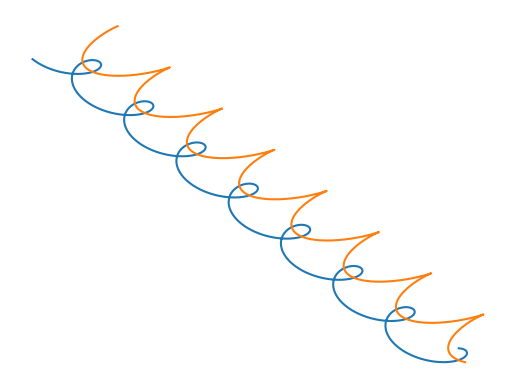

In [3]:

train_positions = datamodule.train_dataset.positions.cpu().numpy()
def plot_training(positions):
    ax = plt.subplot(1,1,1)
    #ax2 = plt.subplot(1,2,2)
    nstep=2000
    nbodies = positions.shape[1]
    
    for i in range(nbodies):
        ax.plot(positions[:nstep,i,0], positions[:nstep,i,1], label='Training {i}')
    ax.axis('off')

plot_training(train_positions.squeeze())

In [4]:
model.train(method, datamodule)

/nfs/scistore19/alistgrp/jiachen/miniconda3/envs/lpode/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/scistore19/alistgrp/jiachen/miniconda3/envs/lpo ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type     | Params
-----------------------------------
0 | model | EPHModel | 12.6 M
-----------------------------------
12.6 M    Trainable params
0         Non-trainable params
12.6 M    Total params
50.220    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/nfs/scistore19/alistgrp/jiachen/miniconda3/envs/lpode/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/nfs/scistore19/alistgrp/jiachen/miniconda3/envs/lpode/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (63) is smaller than the logging interval Trainer(log_every_n_steps=500). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [6]:
idx =0
device='cuda'
NS=50
@torch.no_grad()
def run_inference(method, x,v,idx, steps):
    method.to(device)
    positions = []
    velocities = []
    accs = []
    forces = []
    coeffs_list = []
    for step in range(steps):
        x = x.to(device)
        v = v.to(device)
        
        x_out, v_out = method.inference((x,v))
        
        x = x_out[:,10:NS+10,:,:]
        v = v_out[:,10:NS+10,:,:]
        
        x_out = x_out.squeeze()
        v_out = v_out.squeeze()
        
        x_out = x_out[0,NS:NS+10].squeeze(0).cpu().numpy()
        v_out = v_out[0,NS:NS+10].squeeze(0).cpu().numpy()
        
        positions.append(x_out)
        velocities.append(v_out)
    positions = np.vstack(positions)
    velocities = np.vstack(velocities)
    
    return positions, velocities

x = datamodule.val_dataset.positions
v = datamodule.val_dataset.velocities

print(x.shape)
#Batch size is fixed beforehand. TODO: fix.
#Predict starting from 50 initial steps
initial_x = x[idx:NS,:,:, :].unsqueeze(0).repeat(batch_size,1,1,1,1)
initial_v = v[idx:NS,:,: :].unsqueeze(0).repeat(batch_size,1,1,1,1)
#Generates 2000 steps
positions, velocities = run_inference(method.double(), initial_x.double(), initial_v.double(),idx, steps=200)

positions.shape

torch.Size([2000, 1, 2, 2])


(2000, 2, 2)

In [7]:
val_positions = datamodule.val_dataset.positions.cpu().numpy()
val_positions.shape

positions= positions.squeeze()
val_positions = val_positions.squeeze()

## Plot and Animate Predictions

fig


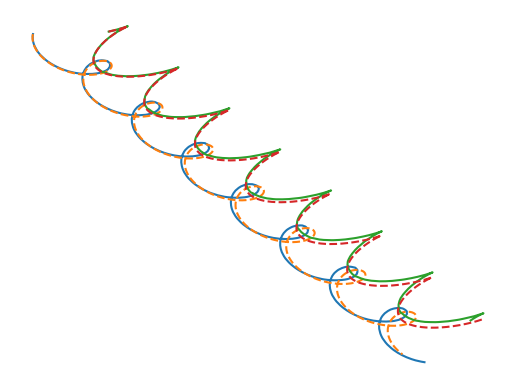

In [8]:
ax = plt.subplot(1,1,1)
#ax2 = plt.subplot(1,2,2)
nstep=2000
nbodies = positions.shape[1]

for i in range(nbodies):
#for i in range(4,5):
    ax.plot(positions[:nstep,i,0], positions[:nstep,i,1], label='pred {i}')
    ax.plot(val_positions[NS:nstep,i,0], val_positions[NS:nstep,i,1], linestyle='--', label='Object {i}')

ax.axis('off')
print('fig')

Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 50.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpmh8vdyzk/temp.m4v


--- Logging error ---
Traceback (most recent call last):
  File "/nfs/scistore19/alistgrp/jiachen/miniconda3/envs/lpode/lib/python3.8/logging/__init__.py", line 1089, in emit
    self.flush()
  File "/nfs/scistore19/alistgrp/jiachen/miniconda3/envs/lpode/lib/python3.8/logging/__init__.py", line 1069, in flush
    self.stream.flush()
OSError: [Errno 116] Stale file handle
Call stack:
  File "/nfs/scistore19/alistgrp/jiachen/miniconda3/envs/lpode/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/nfs/scistore19/alistgrp/jiachen/miniconda3/envs/lpode/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/nfs/scistore19/alistgrp/jiachen/miniconda3/envs/lpode/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/nfs/scistore19/alistgrp/jiachen/miniconda3/envs/lpode/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in lau

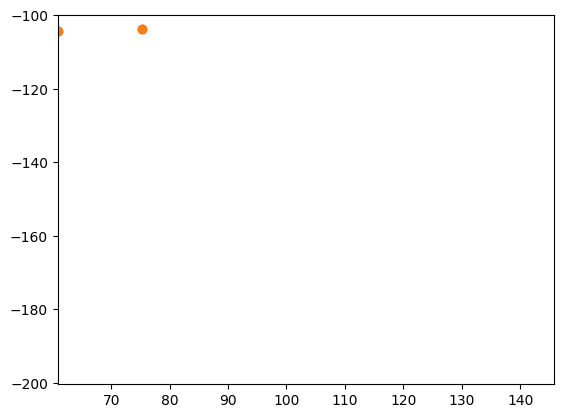

In [9]:
fig, ax = plt.subplots()
def animate(t):
    
    ax.clear()
    ax.set_xlim((val_positions[:,:,0].min(),val_positions[:,:,0].max()))
    ax.set_ylim((val_positions[:,:,1].min(),val_positions[:,:,1].max()))
    
    sc = 10
    x = val_positions[NS+t*sc,:,0]
    y = val_positions[NS+t*sc,:,1]
    
    ax.scatter(x,y)
    tx = positions[t*sc,:,0]
    ty = positions[t*sc,:,1]
    
    ax.scatter(tx,ty)
anim = FuncAnimation(fig, animate, frames=150, interval=20)

HTML(anim.to_html5_video())